In [1]:
# Import packages
import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
import scipy.optimize as opt
%matplotlib inline

In [2]:
def trunc_pdf(xvals, mu, sigma, cutoff='None', lognormal=0, cdf=0):
    if lognormal:
        f_cdf = sts.lognorm.cdf
        f_pdf = sts.lognorm.pdf
        s = sigma
        scale = np.exp(mu)
        if cutoff == 'None':
            prob_notcut = 1.0 - f_cdf(0, s=s, scale=scale)
        else:
            prob_notcut = (f_cdf(cutoff, s=s, scale=scale) - 
                       f_cdf(0, s=s, scale=scale))
        cdf_vals = f_cdf(xvals, s=s, scale=scale)/ prob_notcut
        pdf_vals = f_pdf(xvals, s=s, scale=scale)/ prob_notcut
        
    else:
        f_cdf = sts.norm.cdf
        f_pdf = sts.norm.pdf
        if cutoff == 'None':
            prob_notcut = 1.0 - f_cdf(0, mu=mu, sigma=sigma)
        else:
            prob_notcut = (f_cdf(cutoff, mu=mu, sigma=sigma) - 
               f_cdf(0, mu=mu, sigma=sigma))
        cdf_vals = f_cdf(xvals, mu=mu, scale=sigma)/ prob_notcut
        pdf_vals = f_pdf(xvals, mu=mu, scale=sigma)/ prob_notcut
    
    if cdf:
        return cdf_vals
    else:
        return pdf_vals

In [3]:
def log_lik_trunc(xvals, mu, sigma, cutoff, lognormal=0):
    pdf_vals = trunc_pdf(xvals, mu, sigma, cutoff, lognormal)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

## Problem 1 

In [4]:
# Load Data
income = np.loadtxt('incomes.txt')

In [5]:
def crit1(params, *args, lognormal=1):
    mu, sigma = params
    xvals, cutoff = args
    log_lik_val = log_lik_trunc(xvals, mu, sigma, cutoff, lognormal)
    neg_log_lik_val = -1*log_lik_val

    return neg_log_lik_val

##### (a) Plot a histogram of percentages of the income.txt data with 30 bins. 
Make sure that the bins are weighted using the normed=True option. Make sure your plot has correct x-axis and y-axis labels as well as a plot title.

(0, 150000)

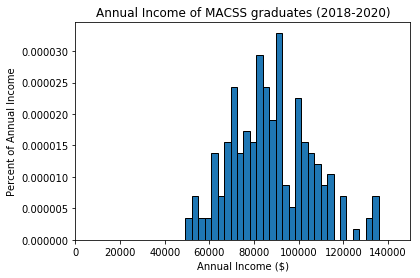

In [6]:
fig1 = plt.figure()

count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)

plt.title('Annual Income of MACSS graduates (2018-2020)')
plt.xlabel(r'Annual Income (\$)')
plt.ylabel(r'Percent of Annual Income')
plt.xlim([0, 150000])

##### (b) Plot the lognormal PDF $$ f(x\mid µ = 11.0;\  σ = 0.5),\   0 ≤ x ≤ 150,000. $$
What is the value of the log likelihood value for this parameterization of
the distribution and given this data?

In [7]:
#generate initial guesses
dist_pts = np.linspace(0, 150000, 150000)
mu = 11.0
sigma = 0.5

(0, 150000)

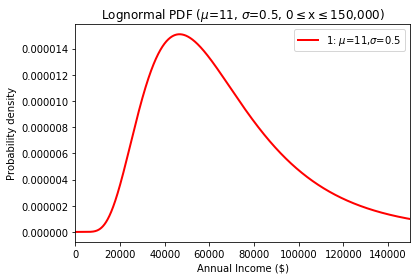

In [8]:
fig2 = plt.figure()

plt.plot(dist_pts, trunc_pdf(dist_pts, mu, sigma, 1500000, 1), linewidth=2, color='r', 
    label='1: $\mu$=11,$\sigma$=0.5')
plt.legend(loc='upper right')
plt.title(r'Lognormal PDF ($\mu$=11, $\sigma$=0.5, 0$\leq$x$\leq$150,000)')
plt.xlabel(r'Annual Income (\$)')
plt.ylabel(r'Probability density')
plt.xlim([0, 150000])

In [9]:
print(f'Log-likelihood (μ=11, σ=0.5):', log_lik_trunc(income, mu, sigma, 150000,1))

Log-likelihood (μ=11, σ=0.5): -2379.12059193


##### (c) Estimate the parameters of the lognormal distribution by maximum likelihood and plot its PDF against the PDF from part (b) and the histogram from part (a). 
Plot the estimated PDF for 0 ≤ x ≤ 150,000. Report the
ML estimates for µ and σ, the value of the likelihood function, and the
variance-covariance matrix.

#### Considering a good guess is focally important to the result, we will set up a two-step sequence to generate the estimation. (First get an estimation of our initial values, then get another estimation by using our first estimation)

In [10]:
mu1 = 11
sig1 = 0.5
cutoff = 150000
results1 = opt.minimize(crit1, np.array([mu1, sig1]), args=(income, cutoff), 
                       bounds = ((1e-10, None), (1e-10, None)), method = 'SLSQP')
mu_MLE, sig_MLE = results1.x

D:\Users\Jiang\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
D:\Users\Jiang\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
D:\Users\Jiang\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
results2 = opt.minimize(crit1, np.array([mu_MLE, sig_MLE]), args=(income, 150000), 
                       bounds = ((1e-10, None), (1e-10, None)), method = 'BFGS')
MU_2, SIG_2 = results2.x

D:\Users\Jiang\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:430: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)


In [12]:
print('mu_MLE=', MU_2, '\nsig_MLE=', SIG_2)
print('Log-likelihood (MLE): ', log_lik_trunc(income, MU_2, SIG_2, 150000,1))

mu_MLE= 11.3616999747 
sig_MLE= 0.2117432661
Log-likelihood (MLE):  -2240.93433751


In [13]:
OffDiagNeg = np.array([[1, -1], [-1, 1]])
vcv_mle = results2.hess_inv * OffDiagNeg
stderr_mu_mle = np.sqrt(vcv_mle[0,0])
stderr_sig_mle = np.sqrt(vcv_mle[1,1])
print('VCV(MLE) = \n', vcv_mle)

VCV(MLE) = 
 [[  2.94107038e-04  -6.03224262e-05]
 [ -6.03224262e-05   1.53115581e-04]]


(0, 150000)

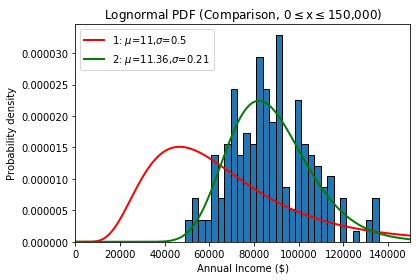

In [14]:
fig3 = plt.figure()

count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)
plt.plot(dist_pts, trunc_pdf(dist_pts, mu, sigma, 1500000, 1), linewidth=2, color='r', 
    label='1: $\mu$=11,$\sigma$=0.5')
plt.plot(dist_pts, trunc_pdf(dist_pts, mu_MLE, sig_MLE, 1500000, 1), linewidth=2, color='g', 
    label=f'2: $\mu$={round(mu_MLE,2)},$\sigma$={round(sig_MLE,2)}')
plt.legend(loc='best')
plt.title(f'Lognormal PDF (Comparison, 0$\leq$x$\leq$150,000)')
plt.xlabel(r'Annual Income (\$)')
plt.ylabel(r'Probability density')
plt.xlim([0, 150000])

##### (d) Perform a likelihood ratio test to determine the probability that the data in incomes.txt came from the distribution in part (b).

In [15]:
cutoff = 150000
log_lik_h0 = log_lik_trunc(income, 11, 0.5, cutoff, 1)
log_lik_mle = log_lik_trunc(income, mu_MLE, sig_MLE, cutoff, 1)
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi-squared test (degrees of freedom = 2) p_value (h0) = ', pval_h0)

chi-squared test (degrees of freedom = 2) p_value (h0) =  0.0


#### Given that our model estimate 2 parameters, we get a p-value of 0.0, this means the data in income.txt unlikely came from the distribution in part (b) (h0).

##### (e) With your estimated distribution of incomes for Chicago MACSS students from part (c), 
you now have a model for what your own income might look like when you graduate. Using that estimated model from part (c), What is the probability that you will earn more than \$100,000? What is the probability that you will earn less than \$75,000?

In [16]:
print('Probability of earning more than $100,000: ', 1- trunc_pdf(100000, sigma = sig_MLE, mu= mu_MLE, cutoff=150000,lognormal=1,cdf=1))
print('Probability of earning less than $75,000: ', trunc_pdf(75000, sigma = sig_MLE, mu= mu_MLE, cutoff=150000, lognormal=1, cdf=1))

Probability of earning more than $100,000:  0.234278207168
Probability of earning less than $75,000:  0.260759454836


## Problem 2

In [17]:
#Load Data
sick = np.loadtxt('sick.txt', skiprows=1, delimiter=',')

In [18]:
def crit2(params, *args):
    b0, b1, b2, b3, sigma = params
    sick, age, children, temp_winter = args
    err = sick - b0 - b1 * age - b2 * children - b3 * temp_winter
    pdf_vals = sts.norm.pdf(err, 0, sigma)
    ln_pdf_vals = np.log(pdf_vals)
    neg_log_lik_val = -1*ln_pdf_vals.sum()
    
    return neg_log_lik_val

##### (a) Estimate the parameters of the model (β0; β1; β2; β3; $σ^2$) by maximum likelihood using the fact that each error term "i is distributed normally N(0, $σ^2$).
We can solve the regression equation for "i which tells us that the following equation is distributed normally N(0; σ2).
            $$sick_i − β_0 − β_1age_i − β_2children_i − β_2temp\_winter_i ∼ N(0, σ^2)$$
Estimate (β0; β1; β2; β3; σ2) to maximize the likelihood of seeing the data in
sick.txt. Report your estimates, the value of the log likelihood function,
and the estimated variance covariance matrix of the estimates.

In [19]:
#Set initial values
b0 = 0
b1 = 0
b2 = 0
b3 = 0
sig = 0.1

#### Considering a good guess is focally important to the result, we will set up a two-step sequence to generate the estimation. (First get an estimation of our initial values, then get another estimation by using our first estimation)

In [20]:
params = np.array([b0, b1, b2, b3, sig])
mle_args = (sick[:,0], sick[:,1], sick[:,2], sick[:,3])
bnds = ((None, None), (None, None), (None, None), (None, None), (1e-10, None))
results2_1 = opt.minimize(crit2, params, args = mle_args, bounds = bnds, method='SLSQP')
b0_MLE1, b1_MLE1, b2_MLE1, b3_MLE1, sig_MLEA = results2_1.x

D:\Users\Jiang\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


In [21]:
params_refined = np.array([b0_MLE1, b1_MLE1, b2_MLE1, b3_MLE1, sig_MLEA])
bnds = ((None, None), (None, None), (None, None), (None, None), (1e-10, None))
results2_2 = opt.minimize(crit2, params_refined, args = mle_args, bounds=bnds, method='L-BFGS-B')
b0_MLE2, b1_MLE2, b2_MLE2, b3_MLE2, sig_MLEB = results2_2.x

D:\Users\Jiang\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
D:\Users\Jiang\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:643: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


In [22]:
params_final = np.array([b0_MLE2, b1_MLE2, b2_MLE2, b3_MLE2, sig_MLEB])

In [23]:
print('Our model yields the following parameter estimates:')
print('b0_MLE = ', b0_MLE2, ' \nb1_MLE = ', b1_MLE2, "\nb2_MLE = ", b2_MLE2, "\nb3_MLE = ", b3_MLE2, "\nsigma_MLE = ", sig_MLEB)
print('\nLog-likelihood (MLE): ', -crit2(params_final, *mle_args))
vcv_mle = results2_2.hess_inv.todense()
OffDiagNeg = -np.ones(vcv_mle.shape) + np.eye(vcv_mle.shape[0])*2
VCV = vcv_mle * OffDiagNeg
print('VCV(MLE) = \n', VCV)

Our model yields the following parameter estimates:
b0_MLE =  0.251646508478  
b1_MLE =  0.0129333453579 
b2_MLE =  0.400502100232 
b3_MLE =  -0.00999167316645 
sigma_MLE =  0.00301766753241

Log-likelihood (MLE):  876.865044902
VCV(MLE) = 
 [[ 1. -0. -0. -0. -0.]
 [-0.  1. -0. -0. -0.]
 [-0. -0.  1. -0. -0.]
 [-0. -0. -0.  1. -0.]
 [-0. -0. -0. -0.  1.]]


##### (b) Use a likelihood ratio test to determine the probability that $$β_0 = 1.0,σ^2 = 0.01 \ and\  β_1, β_2, β_3 = 0.$$
That is, what is the likelihood that age,
number of children, and average winter temperature have no effect on the
number of sick days?

In [24]:
params_h0 = np.array((1,0,0,0,0.1))
log_lik_h0 = -crit2(params_h0, *mle_args)
log_lik_mle = -crit2(params_final, *mle_args)
pval_h0 = 1.0 - sts.chi2.cdf(2 * (log_lik_mle - log_lik_h0), 5)
print('chi-squared test (degrees of freedom = 5) p_value (h0) = ', pval_h0)

chi-squared test (degrees of freedom = 5) p_value (h0) =  0.0


#### Given that our model estimate 5 parameters, we get a p-value of 0.0, this means that there is a very low likelihood that age, number of children, and average winter temperature have no effect on the number of sick days, and we should reject h0.